### Required Capstone Assignment 20.1: Initial Report and Exploratory Data Analysis

In this module, you will work on performing exploratory data analysis (EDA) to develop an initial report for your capstone project. You will use EDA to see what data can reveal beyond the formal modeling, hypothesis testing task, and data training to provide a better understanding of dataset variables and the relationships between them. You are encouraged to spend your time in this module cleaning your data and use feature engineering and EDA techniques to create visualizations to make sense of your findings. Additionally, you will also be required to use one of the ML algorithms you have learned so far in the program to develop a baseline model to use as a comparison in Module 24. You will have time in Module 24 to include additional models, clean the code, and make your work presentable for technical and non-technical audiences. For now, you will do the ‘heavy lifting’ of finding the answer to your research question.

The only deliverables for this module will be the Jupyter notebook(s) where you did your analysis and the updated README.md Download README.mdfile with the results section completed. If you have changed methodologies or datasets since Module 16, please make sure you reflect those changes in the README.md Download README.mdfile as well.



In [3]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Import SKLearn Compose Modules
from sklearn.compose import (
    ColumnTransformer,
)

# Import SKLearn Preprocessing Modules
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    LabelEncoder
)

# Import SKLearn Pipeline
from sklearn.pipeline import Pipeline

# Import SKLearn Model Selection
from sklearn.model_selection import train_test_split

# Import SKLearn Metrics
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    classification_report
)

# Import SKLearn KNN Models
from sklearn.neighbors import KNeighborsClassifier

### Problem Statement

Power information has not been centrally collected and managed and therefore many products have no data.  The goal is to develop a model to estimate typical power for our products where data is unavailable: There will be 3 parts to this project:
   
    1. Using unsupervised learning, group like products together based on BOM information and other categorical data.
    2. Based on the groupings and available data, use a supervised learning module to estimate product weight, as it’s related to product power.
    3. Predict the weight for products with no data. Use this completed data set to create a new supervised learning module to estimate the power for products with no power data.


### Importance

The energy my companies products consume is its largest source of greenhouse gas emissions. By better estimating the power from the products with no data we can more accurately estimate the annual total emissions from the sale of our products.


### Load in initial file with labeled and unlabeled data

In [9]:
# Data source: internal systems

df = pd.read_csv('20250714_MASTER_DATA.csv')
df1 = df

# Manually labeled data that was incorrectly classified
re = pd.read_csv('20250714_reinforcement.csv')

When reviewing the initial file (2050714_MASTER_DATA) it was determined there was some incorrect type items. This was corrected in the file 20250714_reinforcement. The files have been load and combined with the latter replacing the incorrect data of the first.

In [11]:
# Combine re and df1 data where re superceeds df1 data
required_cols = {'TOP_PID', 'MECH_COMP', 'MOD_COMP'}
missing_cols = required_cols - set(re.columns)
if missing_cols:
    raise KeyError(f"The following required columns are missing in 're': {missing_cols}")

# Step 1: Merge re into df on TOP_PID
merged = df1.merge(
    re[['TOP_PID', 'MECH_COMP', 'MOD_COMP']],
    on='TOP_PID',
    how='left',
    suffixes=('', '_new')
)

# Step 2: Replace only if new value is not null
if 'MECH_COMP_new' in merged.columns:
    df1['MECH_COMP'] = merged['MECH_COMP_new'].combine_first(df1['MECH_COMP'])

if 'MOD_COMP_new' in merged.columns:
    df1['MOD_COMP'] = merged['MOD_COMP_new'].combine_first(df1['MOD_COMP'])

# Step 3: Drop temporary columns if they exist
df1.drop(columns=['MECH_COMP_new', 'MOD_COMP_new'], inplace=True, errors='ignore')

This block of code consolidiates item sublcasses that are similar into one feature for simplicitiy. The block also removes products with 0 components and components where a full bill of materials is not available. The data is then split into two, the first will all the items being labeled as mech, mod or power and the second where the label is null.

In [13]:
# Define column groups for clarity and reuse
ic_cols = [
    '01-ASIC Module', '08-ASIC', '15-Logic','15-Communication', '15-Linear', '15-Memory',
    '15-Microprocessor', '15-Multimedia', '15-OptoElectronic', '15-RF', '15-Timing',
    '15-Transducer', '16-Programmable Logic', '16-Programmable Memory', '17-Programmed Device'
]

elec_cols = [
    '11-Capacitor', '12-Resistor', '13-Diode', '18-Delay Line', '19-Crystal-Oscillator-SAW Oscillator',
    '20-Transistor', '21-Filter-Circuit Protection', '22-Switch', '23-Relay',
    '24-Transformer-Inductor-Toroid', '25-LED', '26-Socket'
]

pack_cols = [
    '501-Packaging - Foam', '502-Packaging - Bag-Envelope', '503-Packaging - Wood',
    '504-Packaging - OEM Data', '55-Packaging - Corrugated Component'
]

mech_cols = [
    '48-Screw', '49-Nut-Washer', '50-Standoff-Spacer', '51-General Hardware-Gasket', '51-Heatsink',
    '52-Clip-Clamp', '700-Custom Fabricated - Metal-Plastic', '700-Custom Heatsink', '32-Wire Lug'
]

psu_cols = [
    '34-Off the Shelf Power Supply', '341-Custom Power Supply', '36-Ferrite Array'
]

cable_cols = [
    '31-Raw Wire-Raw Cable', '37-Jack-Power Cord', '72-Cable Assembly-Wiring Harness'
]

kit_cols = [
    '69-Mechanical Kit', '53-Accessory Kit'
]

optical_cols = [
    '05-Optical Passive', '10-Optical Active', '66-Pluggable Optic'
]

# Create category totals
df1['IC'] = df[ic_cols].sum(axis=1)
df1['elec'] = df[elec_cols].sum(axis=1)
df1['pack'] = df[pack_cols].sum(axis=1)
df1['mech'] = df[mech_cols].sum(axis=1)
df1['psu'] = df[psu_cols].sum(axis=1)
df1['cable'] = df[cable_cols].sum(axis=1)
df1['kit'] = df[kit_cols].sum(axis=1)
df1['optical'] = df[optical_cols].sum(axis=1)

# Assign 'type' using priority logic
conditions = [
    df['MECH_COMP'] == 'Y',
    df['MOD_COMP'] == 'Y',
    df['TYP_PWR_W'] > 0,
    df['PROD_PWR_W'] > 0
]
choices = ['mech', 'mod', 'pwr','pwr']

df1['type'] = np.select(conditions, choices, default=np.nan)


# Drop unneeded columns that were combined above

df1 = df1.drop(['300-Liquid Cooling Assy','301-Custom Quick Disconnect Coupling','302-Quick Disconnect Coupling',
               '303-Tubing','304-Pump','305-Coolant', '01-ASIC Module', '08-ASIC', '15-Logic','15-Communication','15-Linear','15-Memory','15-Microprocessor',
               '15-Multimedia','15-OptoElectronic','15-RF','15-Timing','15-Transducer','16-Programmable Logic','16-Programmable Memory',
               '17-Programmed Device','11-Capacitor','12-Resistor','13-Diode','18-Delay Line','19-Crystal-Oscillator-SAW Oscillator',
                 '20-Transistor','21-Filter-Circuit Protection','22-Switch','23-Relay',
                 '24-Transformer-Inductor-Toroid','25-LED','26-Socket','501-Packaging - Foam','502-Packaging - Bag-Envelope','503-Packaging - Wood',
                  '504-Packaging - OEM Data','55-Packaging - Corrugated Component','48-Screw','49-Nut-Washer','50-Standoff-Spacer','51-General Hardware-Gasket','51-Heatsink',
                  '52-Clip-Clamp','700-Custom Fabricated - Metal-Plastic','700-Custom Heatsink','73-Printed Circuit Assembly','800-Assembly-Sub Assembly',
               '800-Heatsink Assembly','84-Packaging Assembly','68-Final Assembl','33-Fan-Blower.1','32-Wire Lug',
               '34-Off the Shelf Power Supply','341-Custom Power Supply','36-Ferrite Array','31-Raw Wire-Raw Cable',
               '37-Jack-Power Cord','72-Cable Assembly-Wiring Harness','69-Mechanical Kit','53-Accessory Kit',
               '05-Optical Passive','10-Optical Active','66-Pluggable Optic','MECH_COMP','MOD_COMP','TYP_PWR_W', 'PROD_PWR_W','POWER_TYPE','PACKAGING_WEIGHT_KG'
                ,'NET_WEIGHT_KG'
              ], axis = 1)

# Summerize total components and create new column

df1['total_comp'] = df1[[
    '06-Audio Equipment', '07-RF Equipment', '28-Printed Circuit Board',
    '29_27-Connector-Header-Terminal', '30-Telecommunications Module', '33-Fan-Blower',
    '35-Battery', '39-Optical Connector-Cable', '43-Video Equipment - Camera-Lens-Image Sensor',
    '43-Video Equipment - Display', '58-Disk Drive', '74-ODM or OEM Assembly',
    'IC', 'elec', 'pack', 'mech', 'psu', 'cable', 'kit', 'optical'
]].sum(axis=1)

# Drop items that have > 1 74- CC and < 200 components

df2 = df1[
    (df1['74-ODM or OEM Assembly'] == 0) |
    ((df1['74-ODM or OEM Assembly'] > 1) & (df1['total_comp'] > 200)) 
]

# Change 'nan' into NaN

df2['type'] = df2['type'].replace(['nan', 'None'], np.nan)
# Drop items that have 0 total compoents

df2 = df2.query('total_comp > 0')

# Split file into labeled (lab) and unlabeled (unlab) data. This is based on type notation.

lab = df2[df2['type'].notna()]   # rows where 'type' is NOT null
unlab = df2[df2['type'].isna()]  # rows where 'type' IS null

/var/folders/wl/swxg00192qzgkm_xpk6tkj_00000gn/T/ipykernel_13382/1946660476.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['type'] = df2['type'].replace(['nan', 'None'], np.nan)


In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41279 entries, 0 to 93433
Data columns (total 25 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   TOP_PID                                        41279 non-null  object
 1   USER_ITEM_TYPE                                 41279 non-null  object
 2   BK_PRODUCT_TYPE_ID                             41279 non-null  object
 3   06-Audio Equipment                             41279 non-null  int64 
 4   07-RF Equipment                                41279 non-null  int64 
 5   28-Printed Circuit Board                       41279 non-null  int64 
 6   29_27-Connector-Header-Terminal                41279 non-null  int64 
 7   30-Telecommunications Module                   41279 non-null  int64 
 8   33-Fan-Blower                                  41279 non-null  int64 
 9   35-Battery                                     41279 non-null  int

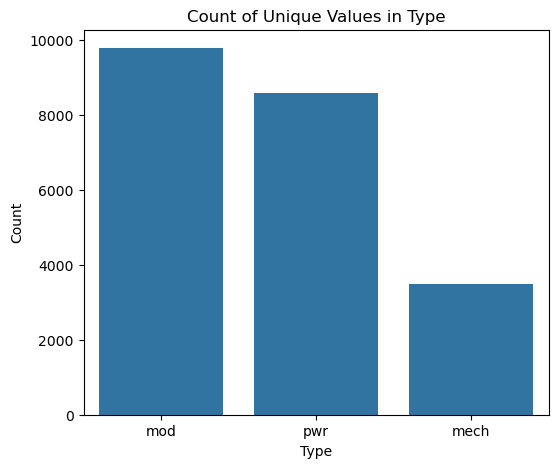

In [15]:
# Get the count of each unique value in the target variable
target_quantity = lab['type'].value_counts(dropna=False)

# Create a bar chart using seaborn
plt.figure(figsize=(6, 5))
sns.barplot(x=target_quantity.index, y=target_quantity.values)

# Add labels and title
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Count of Unique Values in Type')

# Show the plot
plt.show()

In [16]:
# Checking for missing data in labeled data. There is no missing data, all data is either 0 or has a value.

# Count missing per column
missing_count = lab.isnull().sum()

# % missing per column
missing_percent = 100 * lab.isnull().sum() / len(df)

# Combine into one DataFrame
missing_summary = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing %': missing_percent
}).sort_values(by="Missing %", ascending=False)

print(missing_summary)

                                               Missing Count  Missing %
TOP_PID                                                    0        0.0
58-Disk Drive                                              0        0.0
type                                                       0        0.0
optical                                                    0        0.0
kit                                                        0        0.0
cable                                                      0        0.0
psu                                                        0        0.0
mech                                                       0        0.0
pack                                                       0        0.0
elec                                                       0        0.0
IC                                                         0        0.0
74-ODM or OEM Assembly                                     0        0.0
43-Video Equipment - Display                               0    

### Check how balanced data is

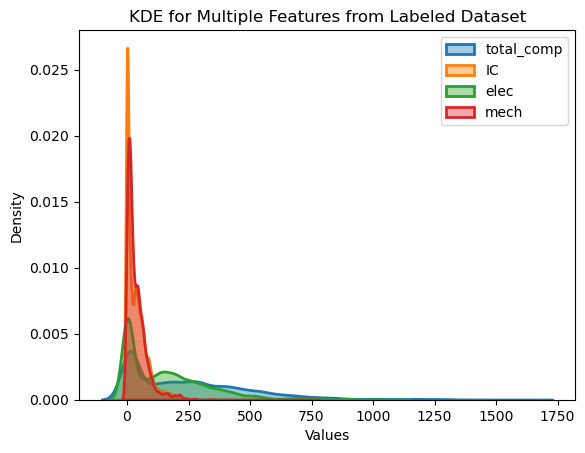

In [18]:
cols = ['total_comp', 'IC', 'elec', 'mech']

for col in cols:
    sns.kdeplot(lab[col], fill=True, linewidth=2, label=col, alpha=0.4)

plt.legend()
plt.title("KDE for Multiple Features from Labeled Dataset")
plt.xlabel('Values')
plt.show()

I selected a few sample features to check to see how skewed the data was. Based on the analysis, there are a lot of products that have smaller values and a longer tail of products with higher values, but fewer of them.

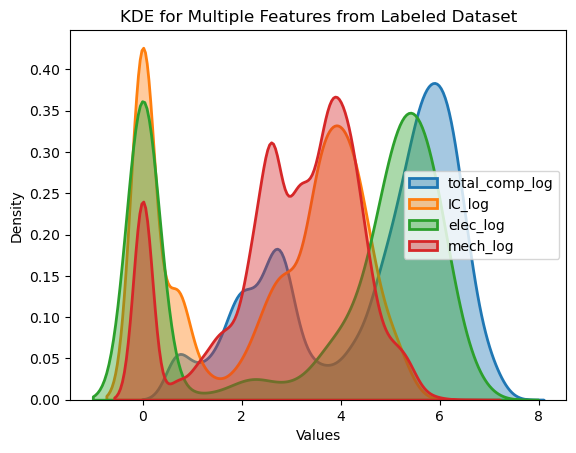

In [20]:

lab3 = pd.DataFrame()

lab3['IC_log'] = np.log1p(lab['IC'])
lab3['elec_log'] = np.log1p(lab['elec'])
lab3['mech_log'] = np.log1p(lab['mech'])
lab3['total_comp_log'] = np.log1p(lab['total_comp'])

cols = ['total_comp_log', 'IC_log', 'elec_log', 'mech_log']


for col in cols:
    sns.kdeplot(lab3[col], fill=True, linewidth=2, label=col, alpha=0.4)

plt.legend()
plt.title("KDE for Multiple Features from Labeled Dataset")
plt.xlabel('Values')
plt.show()

I corrected for the skewness by using a log function which created a more balanced data set which should help with optimizing a model

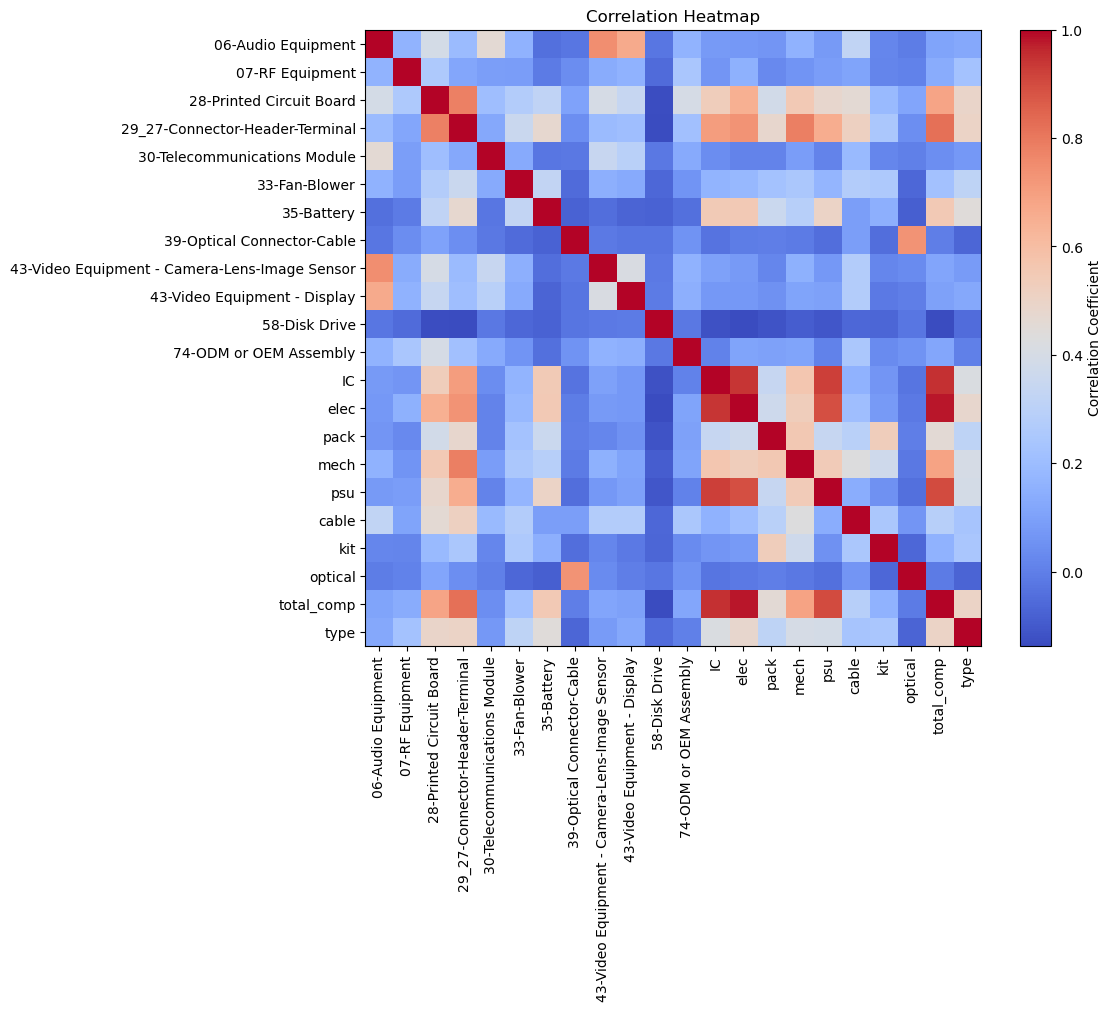

In [22]:
le = LabelEncoder()
lab1 = le.fit_transform(lab['type'])

lab2 = lab.drop('type', axis = 1)
lab2['type'] = lab1

correlation_matrix = lab2.corr(numeric_only=True)

# Heatmap for visualization
plt.figure(figsize=(10,8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title("Correlation Heatmap")
plt.show()

The initial target variable is "type", and base on the correlation matrix is shown to be highly correlated with the following:

- 28-Printed Circuit Board
- 29_27-Connector-Header_Terminal
- IC
- elec
- total_comp

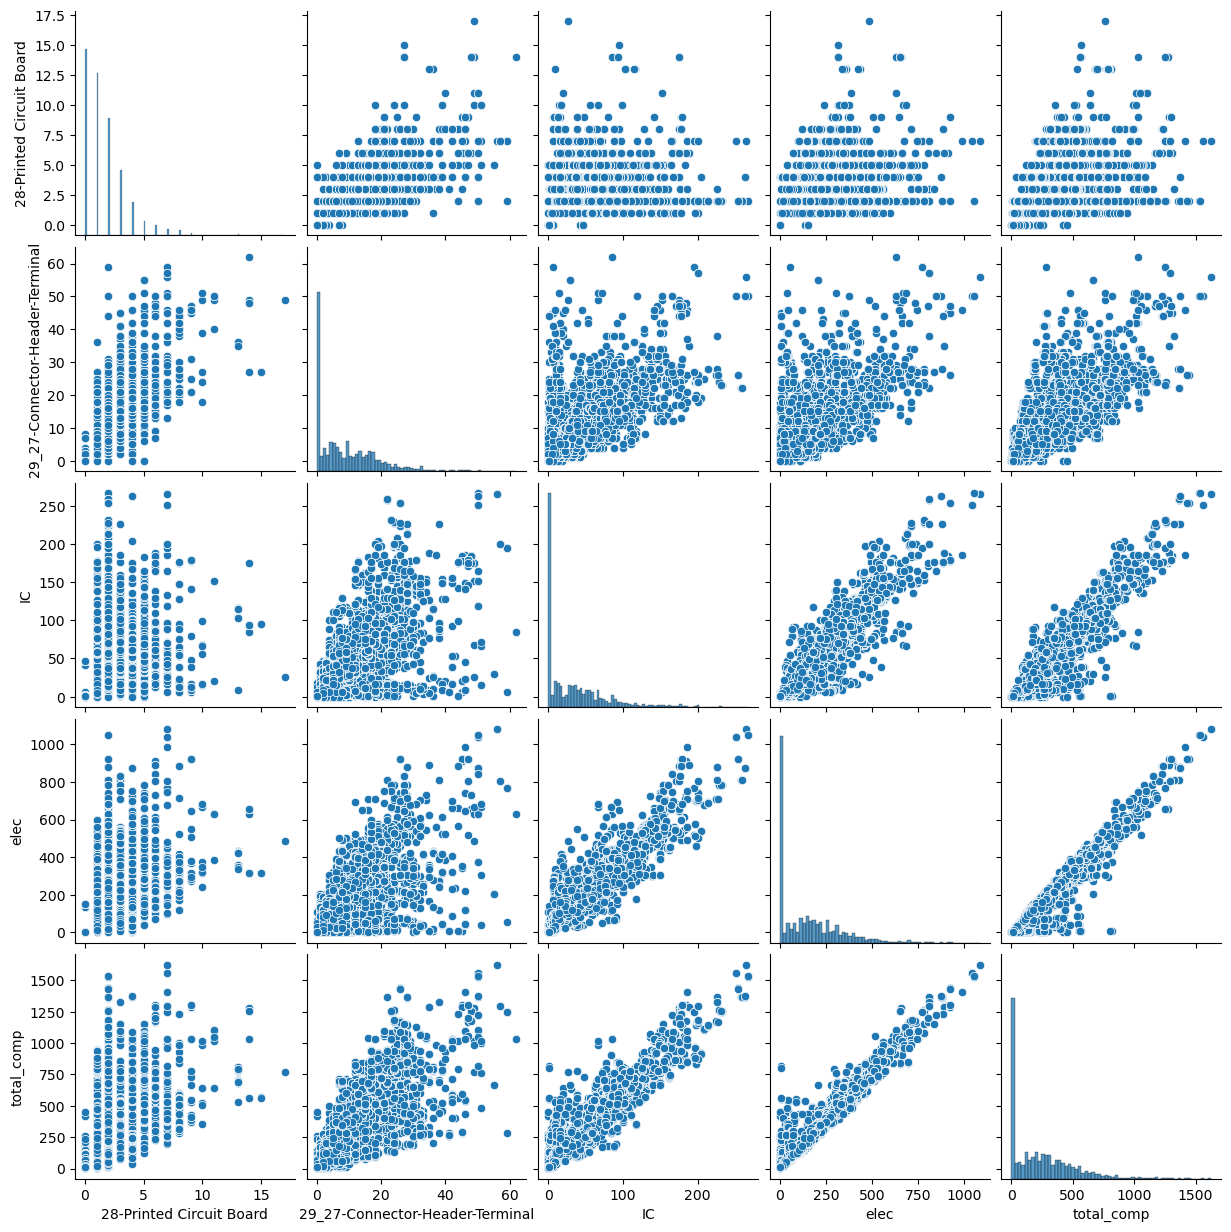

In [24]:
cols = ['28-Printed Circuit Board', 
        '29_27-Connector-Header-Terminal', 
        'IC', 
        'elec', 
        'total_comp'
        ]

sns.pairplot(lab[cols])

The pair plot analysis shows that there is strong linear correlation between the following:

- total_comp vs IC
- total_comp vs elec
- IC vs elec

### Determine Best Classification Model and Hyperparameters for Type Identification

Accuracy Training: 0.95
Accuracy Testing: 0.92


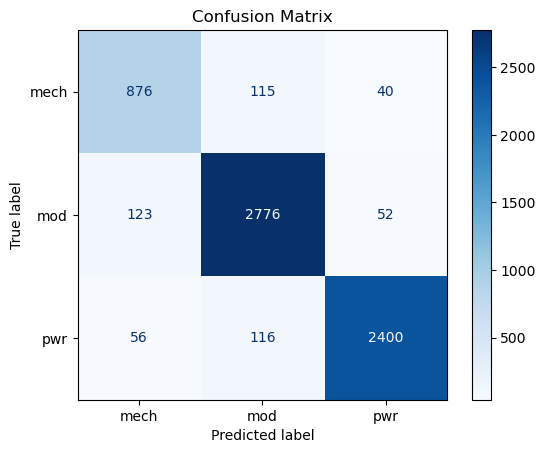

              precision    recall  f1-score   support

        mech       0.83      0.85      0.84      1031
         mod       0.92      0.94      0.93      2951
         pwr       0.96      0.93      0.95      2572

    accuracy                           0.92      6554
   macro avg       0.91      0.91      0.91      6554
weighted avg       0.92      0.92      0.92      6554



In [27]:
# Define features X and target y
X = lab.drop(['type' , 'TOP_PID'], axis=1)
y = lab['type']

# Encode the target variable
le = LabelEncoder()
lab1 = le.fit_transform(y)

# Identify new categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Split the data into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Build ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
    ],
)

# Create a pipeline that includes a preprocessor and classifier and K-Nearest Neighbors classifier model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5)) 
])

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Evaluate the model's performance
accuracy_train = accuracy_score(y_train, y_train_pred)
accuracy_test = accuracy_score(y_test, y_test_pred)

print(f"Accuracy Training: {accuracy_train:.2f}")
print(f"Accuracy Testing: {accuracy_test:.2f}")


cm = confusion_matrix(y_test, y_test_pred, labels=pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_test, y_test_pred)
print(report)